# Explainable Deep Time Series Classification

This notebook presents selected methods for explaining predictions made by a deep neural network based speech classification model. 

In the recent years the need for an explainable Machine Learning has increased drastically. This need is particualrly important when it comes to the ML models that belongs to the class of Deep Neural Networks. The reason for that is that, unlike simpler method such as Linear/Logistic regression or Decision Trees, Neural Networks are largely treated as "Black-Boxes" - systems whose inner structure remains a mystery and we can only characterize them by studying input and outputs. This is problematic, because DNNs are responsible for many breaktroughs in Natural Language Processing, Image Recognition, Speech Recogntion and many more. For some fields (like medicine), however, this lack of transparency is crucial.

Where there is a need, there is progress. A lot of framewroks that ease research on this issue have emarged, most notably SHAP https://github.com/slundberg/shap and https://github.com/marcotcr/lime. 

A particualrily interesting project was developed aiming at explaining predictions made by those Black-boxes - Deep Neural Networks. It is called Captum -> https://github.com/pytorch/captum and is a part of PyTorch - one of the most Deep Learing frameworks, with ~40k stars on GiHub and a growing community of both researchers and engineers. It is also my framework of choice for Deep Learning.

Captum features:
* out of the box support for any PyTorch model
* rich documentation and tutorials
* integration of many different, more and less popular explaination methods, such as Integrated Gradients, Feature Ablation, Gradient SHAP and many others

In [1]:
# this notebook expects the ftdnn module to be installed in your virtual environment
import os

import numpy as np
import torch
import torch.nn as nn
import captum
from captum.attr import IntegratedGradients, FeatureAblation
import matplotlib.pyplot as plt
from matplotlib import cm

import ftdnn

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]

# Classification problem description

I am currently developing a deep learning system for speech-based age estimation. Depending on the dataset we use, we may treat this problem in three ways:
1. As a classification problem. If our data is grouped into age classes, such as 'twenties', 'thirties' and so on, we would train the network to predict this age gorup of the speaker. We then would have a N-class classification problem with N being the number of distinct age groups in our dataset. Such a network would typically be trained with a Cross Entropy loss. The drawback of this approach is mainly the fact that the Cross Entropy loss does not impose any constraint on the distance between the classes, thus treating these two errors in the same way:
```
predicted: twenties, real: thirties
predicted: twenties, real: eighties
```
2. As a regression problem. In this approach we would train the network to predict the exact age of the speaker represented as a real-valued number. Such a network would typically be trained with a Mean Square Error loss. Even though this kind of objective funtion does not suffer from the distance problem (1) does, it has been empirically shown to perform worse then (1)

3. As a multi-task problem. In this approach we would train the network for both classfication and regression problem. The MSE loss would put constraint on the distance between the classes, while the Cross Entropy would stabilize the learning. Authors in https://danielpovey.com/files/2018_interspeech_age_estimation.pdf shows that properly weighted regression loss improves the poerformance of the model. 

In this work currently only approach (1) is implemented. 


# Neural network architecture
After literature research an approach called x-vector has gained much attention in the recent years reaching State-of-the-art results in various speech classification tasks, such as Speaker Identification and Verification. The idea is a neural network-based continuation of the previously dominating approach called i-vectors. Both x-vector and i-vector frameworks are based on a simillar premise. This premise is, given a speech sequence of arbitrary length and content, to embbedd it into a fixed-size feature vector and then use this feature vector in an arbitrary classifier to predict the output class. 

The architecture from the original xvector paper is shown in picture below[2].
![tdnn-xvector](./data/info/tdnn_xvector.png)

The evolution of this architecture is a usage of the F-TDNN network instead of TDNN used in [2][3]. 
This network's architecture is shown below [4] and is different from the baseline TDNN in that it is deeper, uses skip(residual) connections and introduces a mechanism  of factorizing weight matrices into two smaller matrcies for one of which a semi-orthogonlaity constarint is emposed.
![ftdnn-xvector](./data/info/ftdnn_xvector.png)

In this work both this architectures will be used and have been implemented and opensourced in [4], though the F-TDNN training was lacking the semi-orthogonality step and FTDNN network has been performing worse. 

For the classification problem a simple stack of 2 Fully Connected Layers will be used alongside the Cross ENtropy Loss. 

All embedders and classifiers are implemented in PyTorch (huge part of the implementation is taken from [4]). They have been trained using the NeMo framework, a convenient framework developed and mainatianed by NVidia with well-defined modules for working with audio, partiuclarily speech.

# Dataset
In this work I have decided to use the Common Voice dataset [5]. It is an opensource speech dataset initially released by the Mozilla Foundation in 2017. By know it has gathered a few thousands hours of speech in various languages. The languages with the strongest representation are English, French, German and Spanish. Soon also package for polish language will be released. 

Though Common Voice is meant mainly for Large Vocabulary Automatic Speech Recognitions systems, it also contains some metdata about the speakers, mainly gender: [male, female, other] and age group: [teens, twenties,...,eighties]. I am using both this information in the system I am developing, but for the purpose of this notebook only networks trained purely for age classification are used. 

Not all recordings contain data about speakers, so I am only using a subset conatining both gender and age info. 

It constitutes for around ~85 hours of speech in the training set and ~1.5 hours in the test set, with ~1500 utterances in the test set. 

In [3]:
class AgeBackend(nn.Module):

    def __init__(self, embedding_size: int = 512, num_classes: int = 2, mode: str = 'softmax'):
        super().__init__()
        self.layer01 = ftdnn.DenseReLU(embedding_size, embedding_size)
        if mode == 'softmax':
            self.layer02 = ftdnn.DenseSoftmax(embedding_size, num_classes)
        elif mode == 'logits':
            self.layer02 = ftdnn.DenseLogits(embedding_size, num_classes)
        else:
            raise ValueError('Unrecogonized mode {}'.format(mode))

    def forward(self, x):
        x = self.layer01(x)
        x = self.layer02(x)
        return x
    
class TDNNXVectorAgeClassifierPytorch(nn.Module):

    def __init__(self, tdnn_params, classifier_params):
        super(TDNNXVectorAgeClassifierPytorch, self).__init__()
        self.tdnn = ftdnn.TDNN(tdnn_params.get('in_dim', 30))
        self.classifier = AgeBackend(
            classifier_params.get('embedding_size', 512), 
            classifier_params.get('num_classes', 8), 
            classifier_params.get('mode', 'softmax')
        )

    def forward(self, audio_features):
        # ftdnn needs data in BatchTag, ProcessedTimeTag, MFCCSignalTag
        audio_features = torch.transpose(audio_features, 1, 2)
        embedding = self.tdnn(audio_features)
        outputs = self.classifier(embedding)
        return outputs

class FTDNNXVectorAgeClassifierPytorch(nn.Module):

    def __init__(self, ftdnn_params, classifier_params):
        super(FTDNNXVectorAgeClassifierPytorch, self).__init__()
        self.ftdnn = ftdnn.FTDNN(ftdnn_params.get('in_dim', 30))
        self.classifier = AgeBackend(classifier_params.get('embedding_size', 512), classifier_params.get('num_classes', 8), classifier_params.get('mode', 'softmax'))

    def forward(self, audio_features):
        # ftdnn needs data in BatchTag, ProcessedTimeTag, MFCCSignalTag
        audio_features = torch.transpose(audio_features, 1, 2)
        embedding = self.ftdnn(audio_features)
        outputs = self.classifier(embedding)
        return outputs
    
def from_categorical(y: np.ndarray) -> np.uint8:
    """Return num class from one hot encoded tensor i.e. [0, 0, 1, 0] will return 2 """
    return np.argmax(y)
    
def __gather_predicted_classes(predictions_list: list, labels: list) -> list:
    results = []
    labels_map = dict([(i, labels[i]) for i in range(len(labels))])
    for prediction in predictions_list:
        if len(labels) == 2:
            prediction_lc = np.round(prediction.float().cpu().numpy())[0].astype(np.int)
        elif len(labels) > 2:
            prediction_lc = from_categorical(prediction.cpu().numpy())
        else:
            raise ValueError('Invalid labels length {}'.format(len(labels)))
        results.append(labels_map[prediction_lc])

    return results
    
def post_process_predictions(predictions_list: list, labels: list) -> list:
    return __gather_predicted_classes(predictions_list, labels)

# Models accuracy
Only pretrained networks are available without the code to train them. For the evaluation I am using previously extracted features. Both networks were trained with the same feature extraction pipeline and the features I decided to use are the MFCCs. The feature extraction parameters are the following:
```
    window_size: 0.025  # size of the window for the spectrogram 
    window_stride: 0.01 # slide of the window for the spectrogram 
    window: "hamming"   # windows function for the spectrogram 
    lowfreq: 40         # down cut down frequency
    highfreq: 8000      # high cut down frequency (most of the speaker related features are located in the 40-8000 Hz range of the spectrum so analyzing anything below and above does not make sense)
    n_mfcc: 30          # num of features
    dither: 000001
    pad_to: 16.
    

```


1. The TDNN-based network reaches around **92%** accuracy on the Common Voice test set and was trained for around 8h on a single NVidia Qudro RTX5000 GPU with a batch_size of 16 and 100 epochs.
2. The FTDNN-based network reaches around **85%** accuracy on the same Common Voice test set was trained for around 24h on a single NVidia Qudro RTX5000 GPU with a batch_size of 16 and 100 epochs.


In [13]:
pytorch_embedder = TDNNXVectorAgeClassifierPytorch(
    tdnn_params={
        'in_dim': 30,
    },
    classifier_params={
        'embedding_size': 512,
        'num_classes': 8,
        'mode': 'logits'
    }
)

In [14]:
checkpoint_dir = 'pretrained_models/tdnn/checkpoint.pt'
pytorch_embedder.load_state_dict(torch.load(checkpoint_dir))
pytorch_embedder.eval()

TDNNXVectorAgeClassifierPytorch(
  (tdnn): TDNN(
    (frame1): TDNNLayer(
      (kernel): Conv1d(30, 512, kernel_size=(5,), stride=(1,))
      (nonlinearity): ReLU()
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (frame2): TDNNLayer(
      (kernel): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(2,))
      (nonlinearity): ReLU()
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (frame3): TDNNLayer(
      (kernel): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(3,))
      (nonlinearity): ReLU()
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (frame4): TDNNLayer(
      (kernel): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
      (nonlinearity): ReLU()
      (bn): BatchNorm

In [4]:
def load_wavs():
    wavs = []
    wavs_dir = 'data/wavs'
    wavs_filenames = [filename for filename in os.listdir(wavs_dir) if 'wav' in filename]
    for wav_filename in wavs_filenames:
        wavs.append((wav_filename, np.load(os.path.join(wavs_dir, wav_filename))))
    return wavs

def load_mfccs():
    mfccs = []
    mfccs_dir = 'data/mfccs'
    mfccs_filenames = [filename for filename in os.listdir(mfccs_dir) if 'mfcc' in filename]
    for mfcc_filename in mfccs_filenames:
        mfccs.append((mfcc_filename, np.load(os.path.join(mfccs_dir, mfcc_filename))))
    return mfccs

def load_classes():
    classes = []
    classes_dir = 'data/classes'
    classes_filenames = [filename for filename in os.listdir(classes_dir) if 'class' in filename]
    for class_filename in classes_filenames:
        classes.append((class_filename, np.load(os.path.join(classes_dir, class_filename))))
    return classes

def get_real_class(name):
    return name.split('_')[1].split('.')[0]

# Explaination algorithms

I have decided to try out two algorithms: Intergrated Gradients and Feature Ablation

1. Integrated Gradients:
Integrated gradients represents the integral of gradients with respect to inputs along the path from a given baseline to input. The integral can be approximated using a Riemann Sum or Gauss Legendre quadrature rule. Formally, it can be described as follows:

![integrated-gradients](./data/info/ig_equation.png)

Integrated Gradients along the i - th dimension of input X. Alpha is the scaling coefficient. The equations are copied from the original paper.

The cornerstones of this approach are two fundamental axioms, namely sensitivity and implementation invariance. More information regarding these axioms can be found in the original paper.

2. Feature Ablation
Feature ablation is a perturbation based approach to compute attribution, involving replacing each input feature with a given baseline / reference value (e.g. 0), and computing the difference in output. Input features can also be grouped and ablated together rather than individually. This can be used in a variety of applications. For example, for images, one can group an entire segment or region and ablate it together, measuring the importance of the segment (feature group).

wav_eighties.npy mfcc_eighties.npy
network prediction: [[ 3.0646107   0.8872832  -2.4843242  -1.4130279  -5.3649225  -0.03986621
   2.8079686   2.5553827 ]]
predicted: ['teens'], real class: eighties


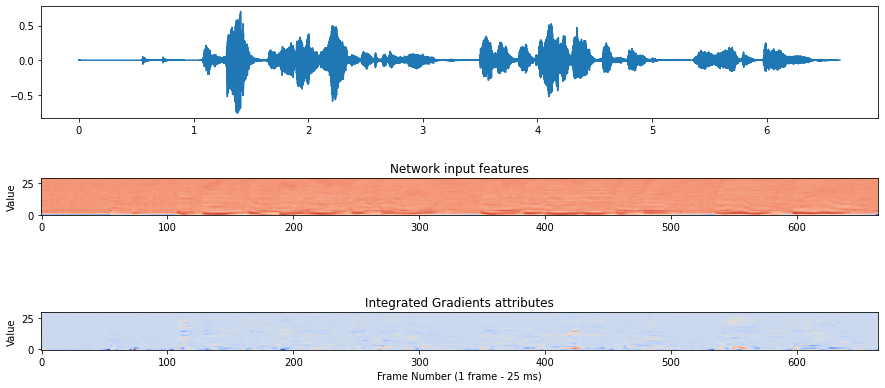

wav_fifties.npy mfcc_fifties.npy
network prediction: [[  0.33479452 -49.401745    11.8042965   -4.1163297   37.033962
   -0.7913718    3.026516     2.1084814 ]]
predicted: ['fifties'], real class: fifties


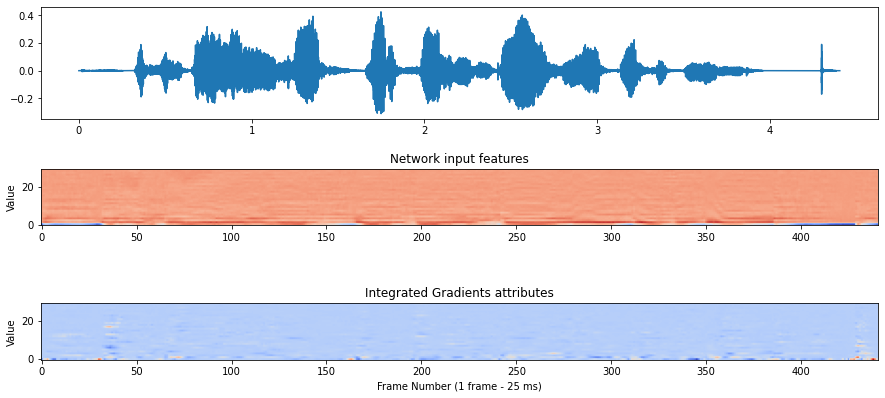

wav_fourties.npy mfcc_fourties.npy
network prediction: [[ -9.902435   -7.973635   -8.739233   40.352825   -3.5192795 -13.082677
    5.507105   -2.6514864]]
predicted: ['fourties'], real class: fourties


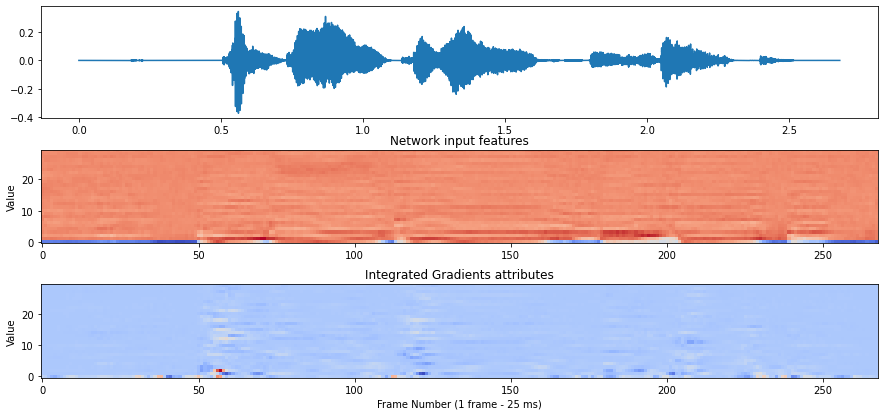

wav_seventies.npy mfcc_seventies.npy
network prediction: [[ 10.329803   -25.87305    -37.03365      0.33786795 -13.011906
    6.6826086   47.669216    10.880729  ]]
predicted: ['seventies'], real class: seventies


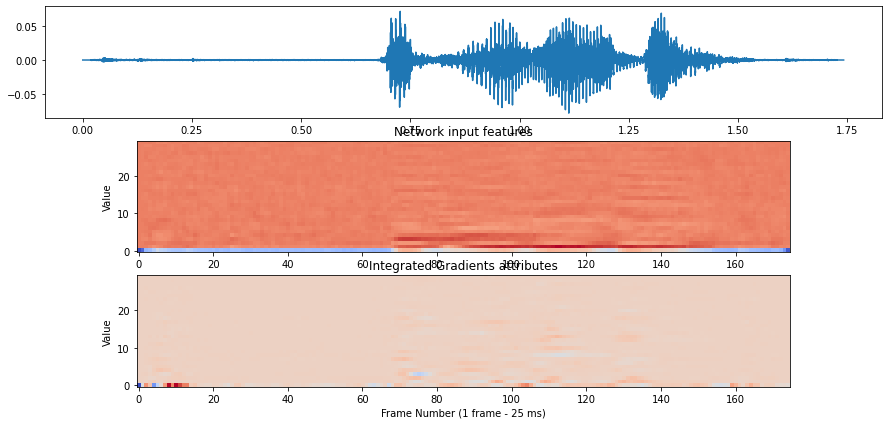

wav_sixties.npy mfcc_sixties.npy
network prediction: [[ -0.6358677  -0.6150241 -14.509293   -2.3809507  -0.9701512  20.12123
   -2.9505682   1.9456484]]
predicted: ['sixties'], real class: sixties


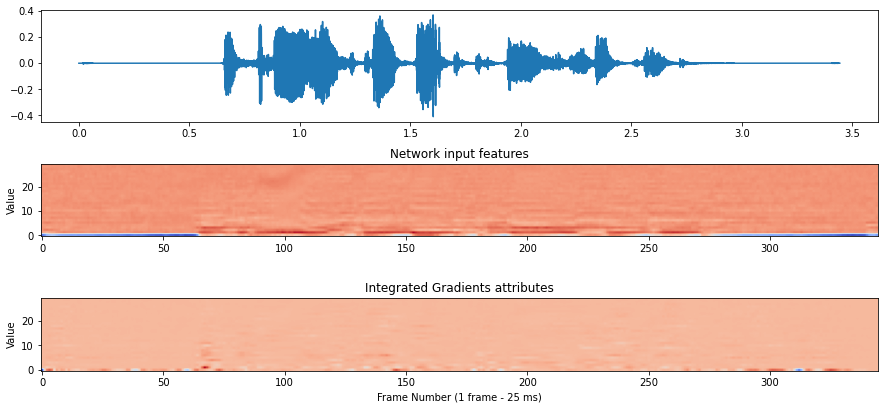

wav_teens.npy mfcc_teens.npy
network prediction: [[ 20.654076  -31.3273      4.5192676   4.5692606   2.073344   -2.200029
   -1.350956    3.079873 ]]
predicted: ['teens'], real class: teens


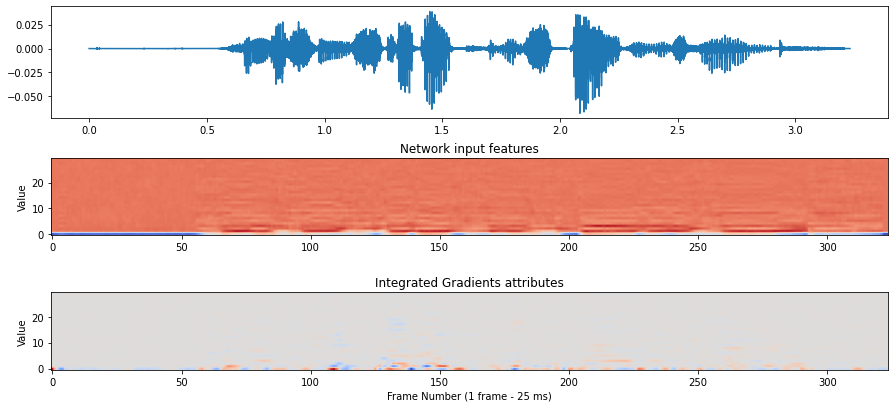

wav_thirties.npy mfcc_thirties.npy
network prediction: [[-1.5307438  4.9477673  4.0075674  6.3581276  2.9189606 -5.9822855
  -8.295762  -2.422224 ]]
predicted: ['fourties'], real class: thirties


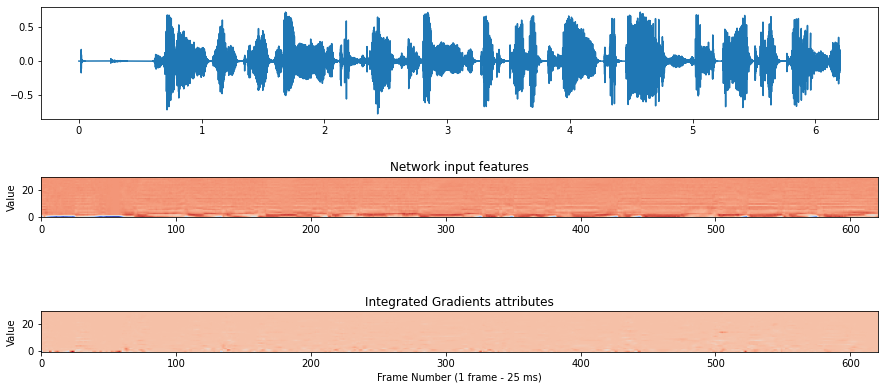

wav_twenties.npy mfcc_twenties.npy
network prediction: [[  3.7732146   14.529268    -3.2628074  -12.079282    -3.727316
    5.814519    -5.0114594   -0.03693603]]
predicted: ['twenties'], real class: twenties


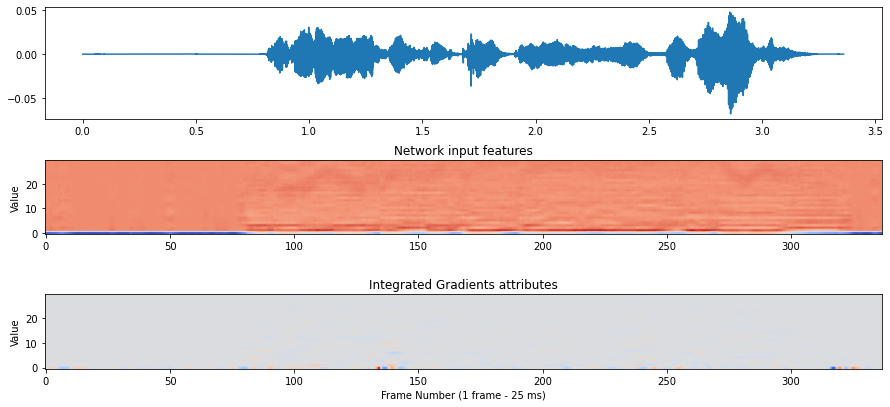

wav_eighties.npy mfcc_eighties.npy
network prediction: [[ 3.0646107   0.8872832  -2.4843242  -1.4130279  -5.3649225  -0.03986621
   2.8079686   2.5553827 ]]
predicted: ['teens'], real class: eighties


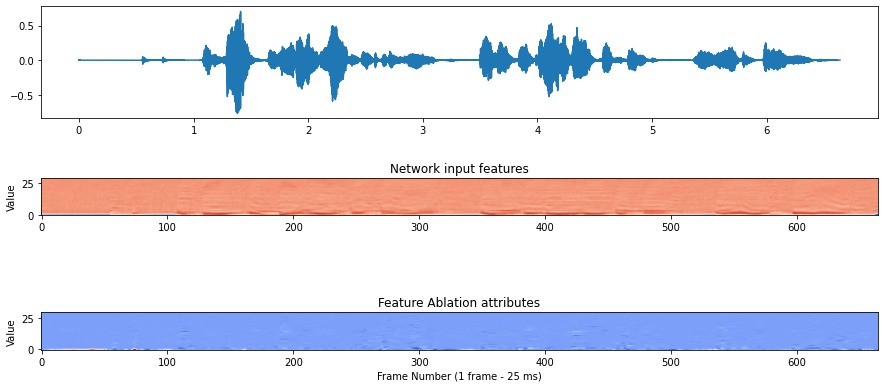

wav_fifties.npy mfcc_fifties.npy
network prediction: [[  0.33479452 -49.401745    11.8042965   -4.1163297   37.033962
   -0.7913718    3.026516     2.1084814 ]]
predicted: ['fifties'], real class: fifties


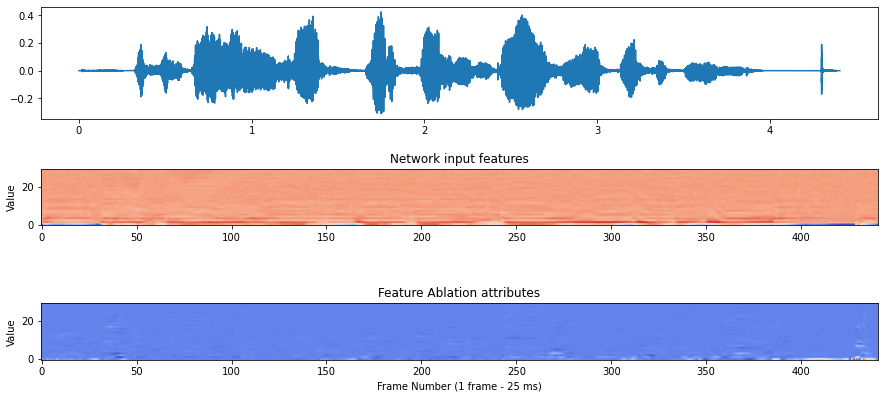

wav_fourties.npy mfcc_fourties.npy
network prediction: [[ -9.902435   -7.973635   -8.739233   40.352825   -3.5192795 -13.082677
    5.507105   -2.6514864]]
predicted: ['fourties'], real class: fourties


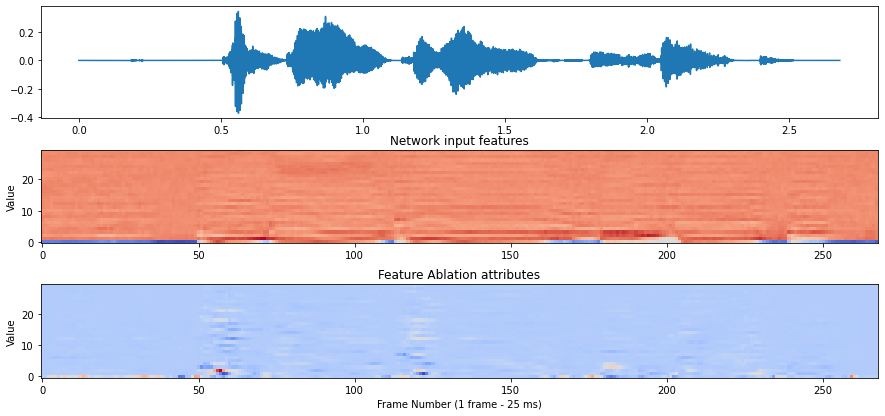

wav_seventies.npy mfcc_seventies.npy
network prediction: [[ 10.329803   -25.87305    -37.03365      0.33786795 -13.011906
    6.6826086   47.669216    10.880729  ]]
predicted: ['seventies'], real class: seventies


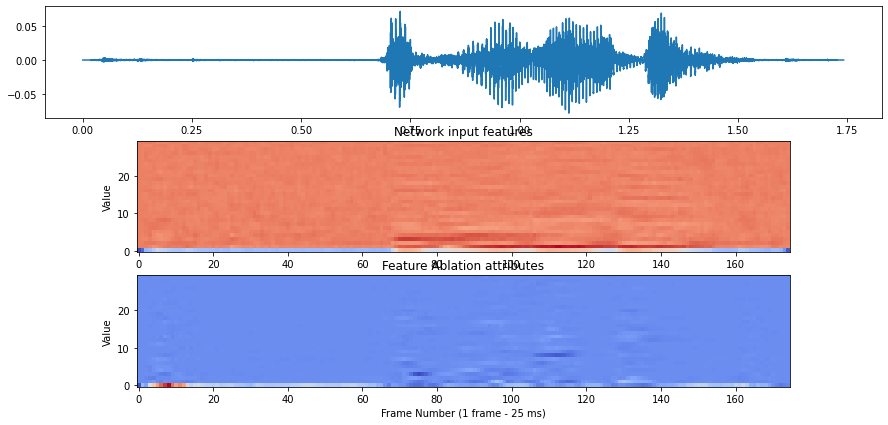

wav_sixties.npy mfcc_sixties.npy
network prediction: [[ -0.6358677  -0.6150241 -14.509293   -2.3809507  -0.9701512  20.12123
   -2.9505682   1.9456484]]
predicted: ['sixties'], real class: sixties


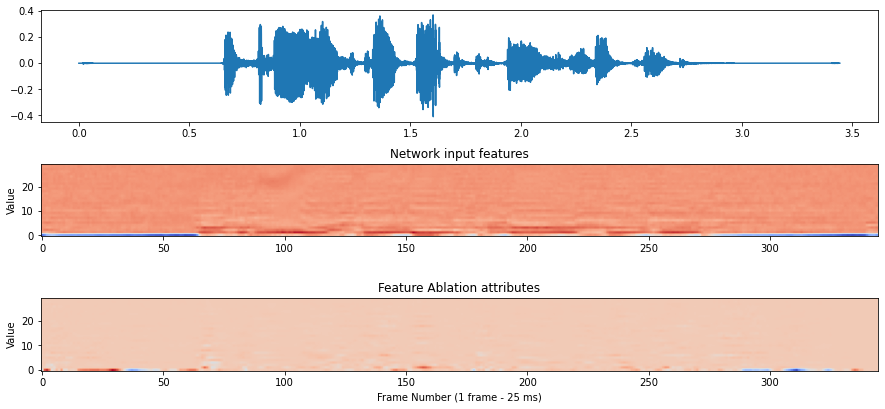

wav_teens.npy mfcc_teens.npy
network prediction: [[ 20.654076  -31.3273      4.5192676   4.5692606   2.073344   -2.200029
   -1.350956    3.079873 ]]
predicted: ['teens'], real class: teens


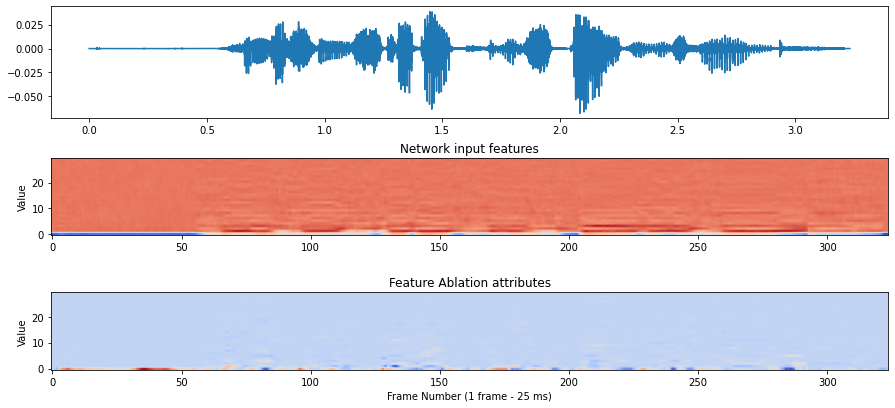

wav_thirties.npy mfcc_thirties.npy
network prediction: [[-1.5307438  4.9477673  4.0075674  6.3581276  2.9189606 -5.9822855
  -8.295762  -2.422224 ]]
predicted: ['fourties'], real class: thirties


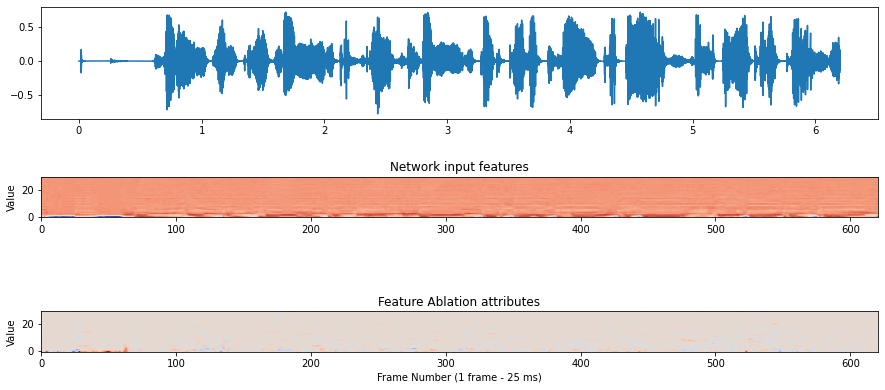

wav_twenties.npy mfcc_twenties.npy
network prediction: [[  3.7732146   14.529268    -3.2628074  -12.079282    -3.727316
    5.814519    -5.0114594   -0.03693603]]
predicted: ['twenties'], real class: twenties


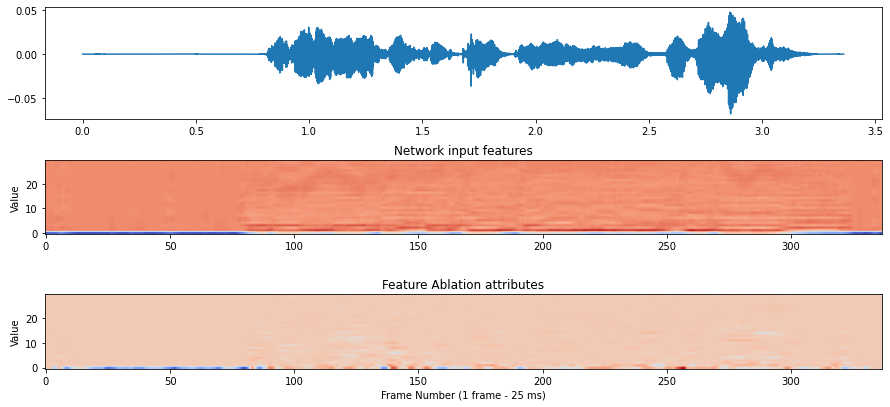

In [16]:
cuda0 = torch.device('cuda:0') 
labels = [
    'teens', 'twenties',  'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'
]
example_id = 0
wavs = sorted(load_wavs(), key=lambda x: x[0])
mfccs = sorted(load_mfccs(), key=lambda x: x[0])
classes = sorted(load_classes(), key=lambda x: x[0])
explain_methods = ['ig', 'fa']
labels_map = dict([(labels[i], i) for i in range(len(labels))])
pytorch_embedder = pytorch_embedder.to(cuda0)
for explain_method in explain_methods:
    for (wav_name, wav), (mfcc_name, mfcc), (class_name, class_) in zip (wavs, mfccs, classes):
        print(wav_name, mfcc_name)
        pytorch_embedder.zero_grad()

        test_input_tensor = torch.FloatTensor(mfcc)
        test_input_tensor = test_input_tensor.to(cuda0)

        with torch.no_grad():
            prediction = pytorch_embedder.forward(test_input_tensor)
            print(f"network prediction: {prediction.detach().cpu().numpy()}")

            real_class = get_real_class(mfcc_name)
            predicted_class = post_process_predictions(prediction.detach(), labels)
            print(f"predicted: {predicted_class}, real class: {real_class}")

        class_label = torch.LongTensor(class_)
        class_label = class_label.to(cuda0)

        if explain_method == 'ig':
            ig = IntegratedGradients(pytorch_embedder)
            test_input_tensor.requires_grad_()        
            attr, delta = ig.attribute(test_input_tensor, target=class_label, return_convergence_delta=True)
            attr = attr.cpu().detach().numpy()
            attribute_plot_title = 'Integrated Gradients attributes'
        elif explain_method == 'fa':
            fa = FeatureAblation(pytorch_embedder)
            attr = fa.attribute(test_input_tensor, target=class_label)
            attr = attr.cpu().detach().numpy()
            attribute_plot_title = 'Feature Ablation attributes'
        else:
            raise ValueError('unrecognized explain method {}'.format(args.explain_method ))

        # plot the results
        fig, axs = plt.subplots(3, 1, sharex=False, sharey=False)
        dpi = 200
        sample_rate = 48000
        axs[0].plot([i/sample_rate for i in range(wav[0].shape[0])], wav[0])

        axs[1].imshow(test_input_tensor.cpu().detach().numpy()[0], cmap=cm.coolwarm, origin='lower')
        axs[1].set_title('Network input features')
        axs[1].set_ylabel('Value')

        axs[2].imshow(attr[0], cmap=cm.coolwarm, origin='lower')
        axs[2].set_title(attribute_plot_title)
        axs[2].set_xlabel('Frame Number (1 frame - 25 ms)')
        axs[2].set_ylabel('Value')
        plt.show()


wav_eighties.npy mfcc_eighties.npy
network prediction: [[-4.7926474  -9.031475    7.4740176  -3.4275577   0.37868577  9.54146
  -0.9988278   0.8540603 ]]
predicted: ['sixties'], real class: eighties


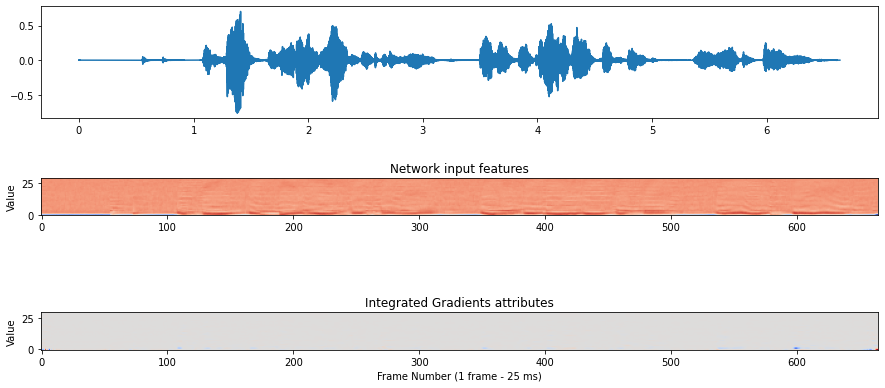

wav_fifties.npy mfcc_fifties.npy
network prediction: [[ -3.7537792 -11.549669    2.1424735  -6.6901693  23.322498   -3.7380464
   -1.7193621   1.9821523]]
predicted: ['fifties'], real class: fifties


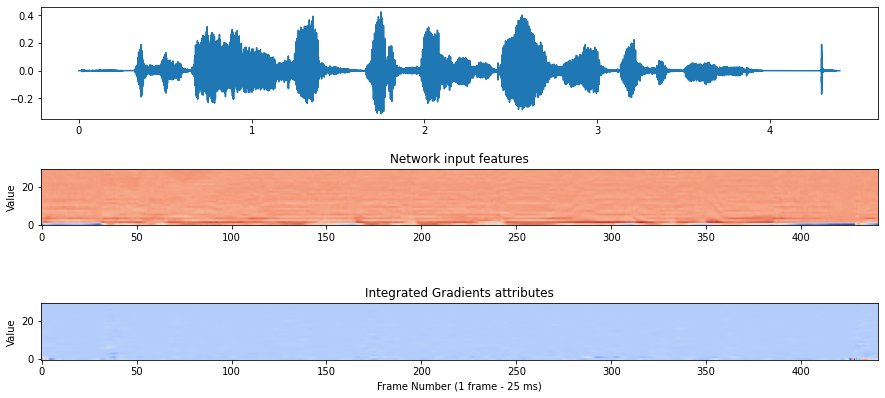

wav_fourties.npy mfcc_fourties.npy
network prediction: [[ -5.902529   -31.613724    -6.9677577   24.175156     3.1410298
    0.04730988  13.059158     4.062706  ]]
predicted: ['fourties'], real class: fourties


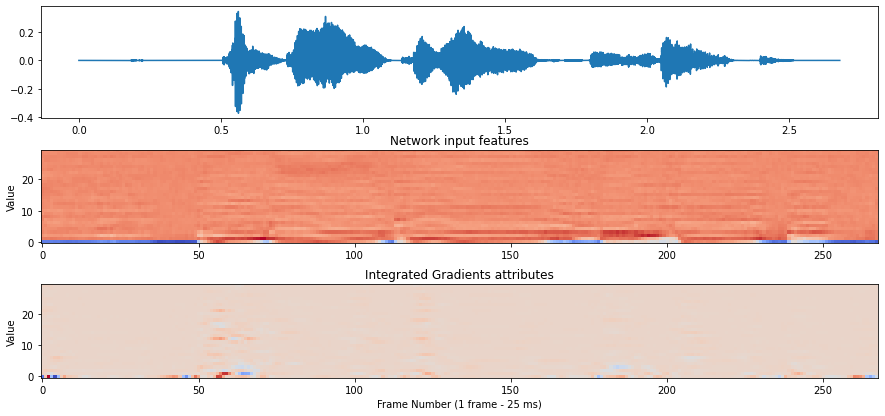

wav_seventies.npy mfcc_seventies.npy
network prediction: [[  2.106435   -6.839642  -20.715416    2.3144603 -20.01956    -5.1776648
   47.34824     0.9600631]]
predicted: ['seventies'], real class: seventies


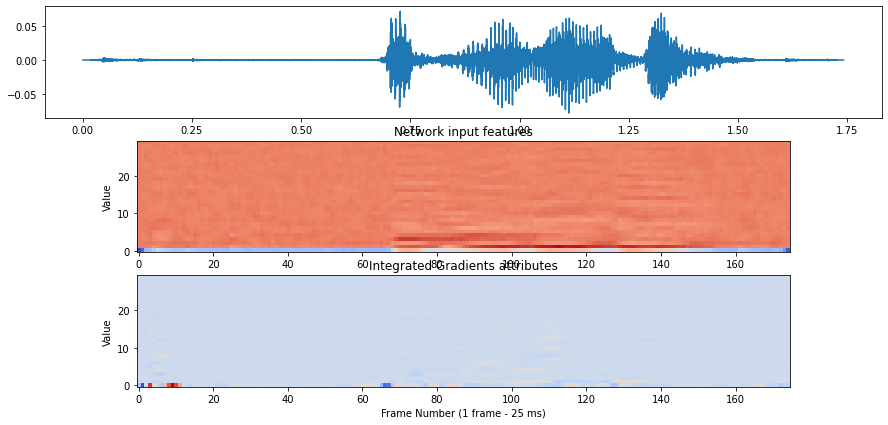

wav_sixties.npy mfcc_sixties.npy
network prediction: [[ -6.418057   -16.826275   -11.023166     0.91252285   4.718463
   20.107225     4.739251     3.7803698 ]]
predicted: ['sixties'], real class: sixties


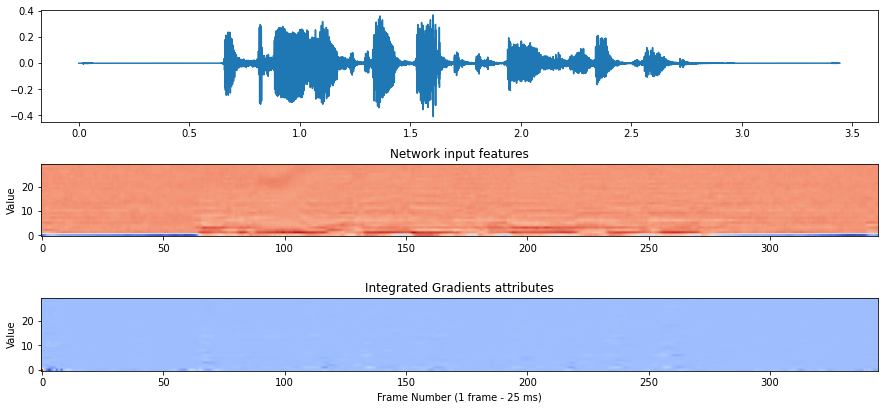

wav_teens.npy mfcc_teens.npy
network prediction: [[ 18.517818    6.087975   -3.2674053  -2.3619509  -5.3723025 -14.091299
    3.032919   -2.5735402]]
predicted: ['teens'], real class: teens


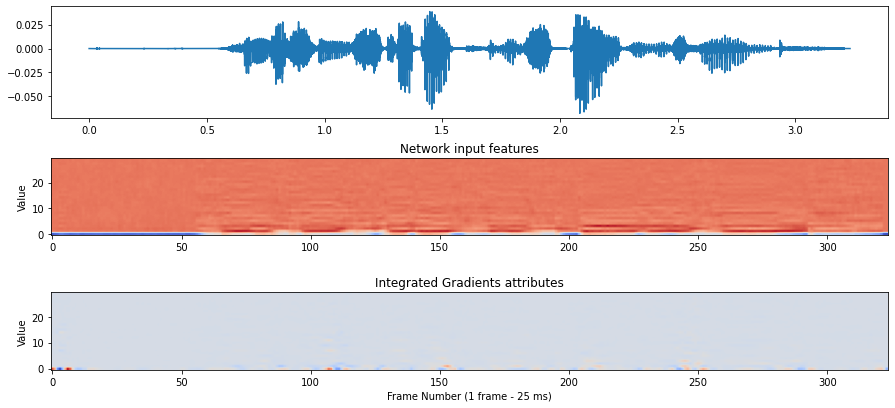

wav_thirties.npy mfcc_thirties.npy
network prediction: [[ 5.709316   2.647371   6.663629   5.8077717 -0.8539151 -9.260188
  -7.919195  -2.8035183]]
predicted: ['thirties'], real class: thirties


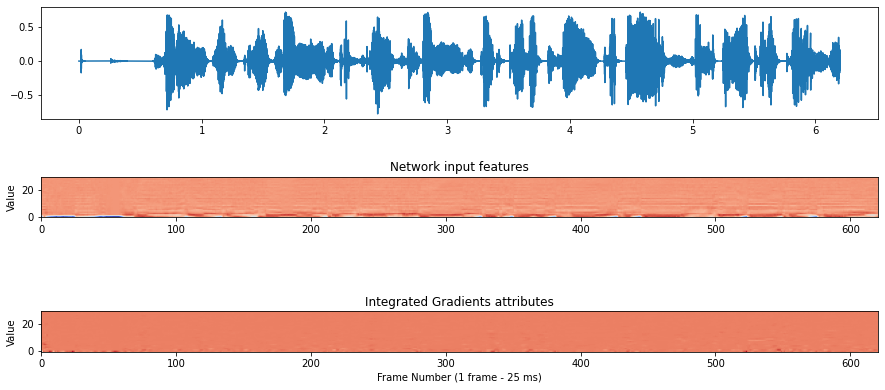

wav_twenties.npy mfcc_twenties.npy
network prediction: [[-6.4007783  16.028076   -9.895983    1.5514097   1.3763075  -6.2818937
   4.435958   -0.78774047]]
predicted: ['twenties'], real class: twenties


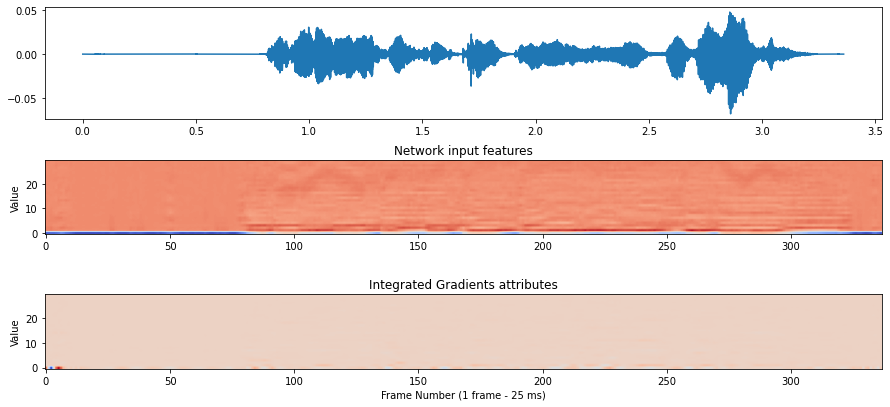

wav_eighties.npy mfcc_eighties.npy
network prediction: [[-4.7926474  -9.031475    7.4740176  -3.4275577   0.37868577  9.54146
  -0.9988278   0.8540603 ]]
predicted: ['sixties'], real class: eighties


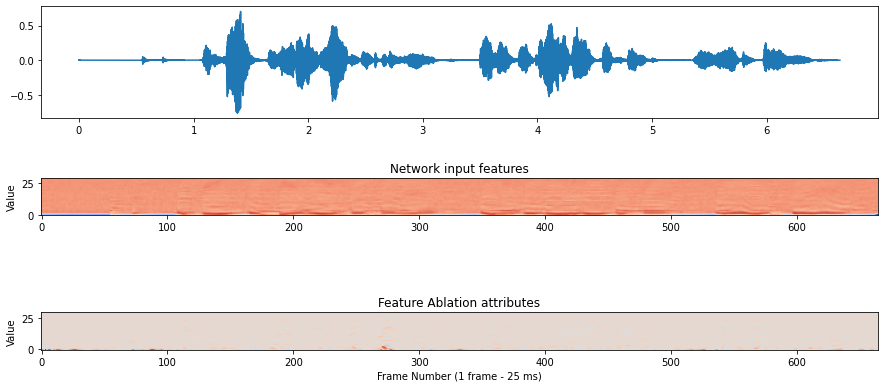

wav_fifties.npy mfcc_fifties.npy
network prediction: [[ -3.7537792 -11.549669    2.1424735  -6.6901693  23.322498   -3.7380464
   -1.7193621   1.9821523]]
predicted: ['fifties'], real class: fifties


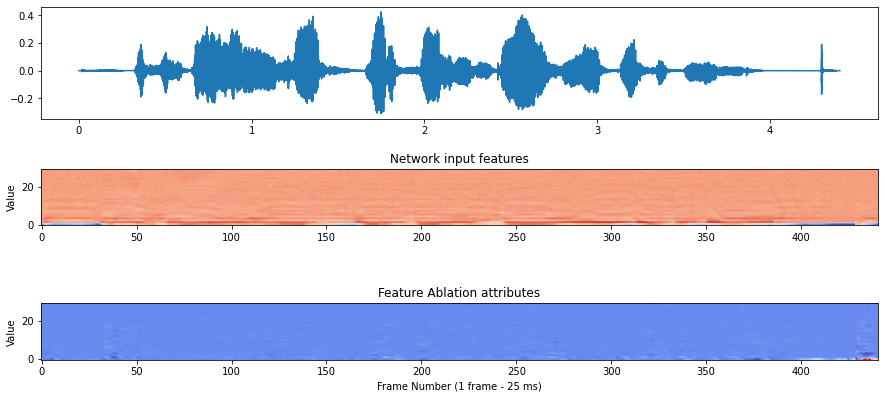

wav_fourties.npy mfcc_fourties.npy
network prediction: [[ -5.902529   -31.613724    -6.9677577   24.175156     3.1410298
    0.04730988  13.059158     4.062706  ]]
predicted: ['fourties'], real class: fourties


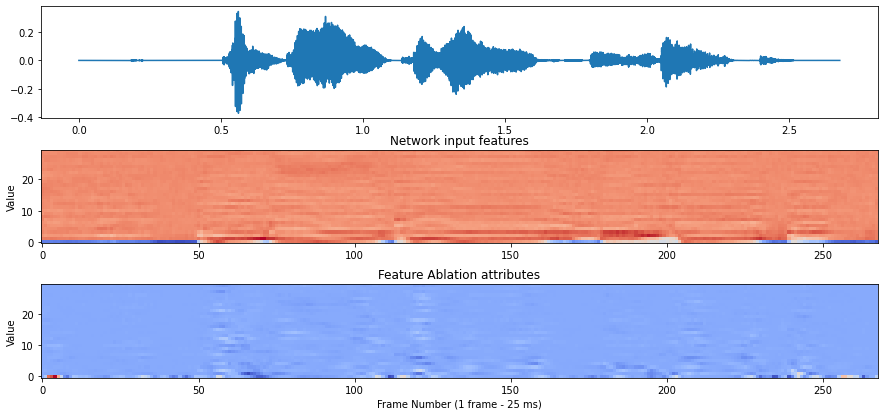

wav_seventies.npy mfcc_seventies.npy
network prediction: [[  2.106435   -6.839642  -20.715416    2.3144603 -20.01956    -5.1776648
   47.34824     0.9600631]]
predicted: ['seventies'], real class: seventies


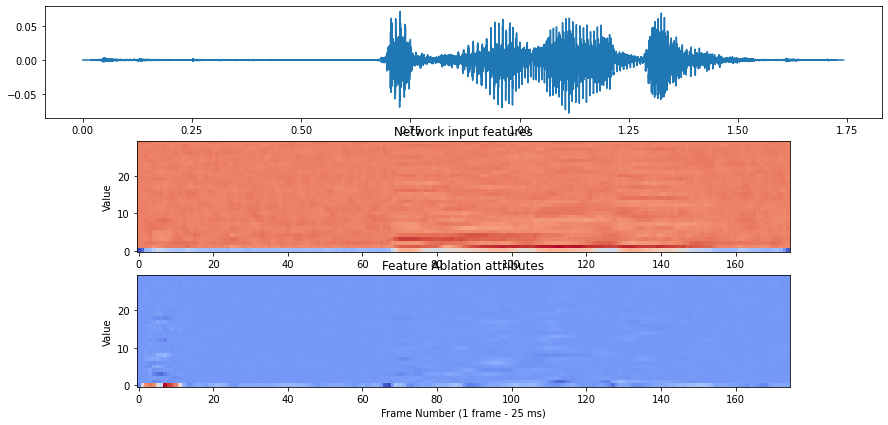

wav_sixties.npy mfcc_sixties.npy
network prediction: [[ -6.418057   -16.826275   -11.023166     0.91252285   4.718463
   20.107225     4.739251     3.7803698 ]]
predicted: ['sixties'], real class: sixties


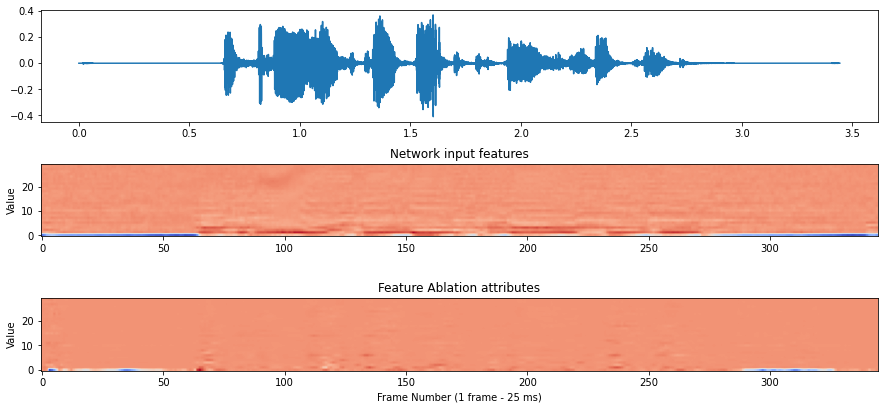

wav_teens.npy mfcc_teens.npy
network prediction: [[ 18.517818    6.087975   -3.2674053  -2.3619509  -5.3723025 -14.091299
    3.032919   -2.5735402]]
predicted: ['teens'], real class: teens


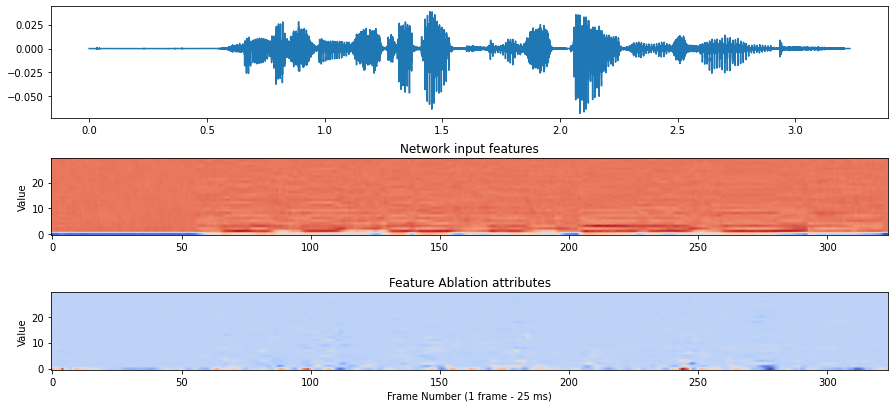

wav_thirties.npy mfcc_thirties.npy
network prediction: [[ 5.709316   2.647371   6.663629   5.8077717 -0.8539151 -9.260188
  -7.919195  -2.8035183]]
predicted: ['thirties'], real class: thirties


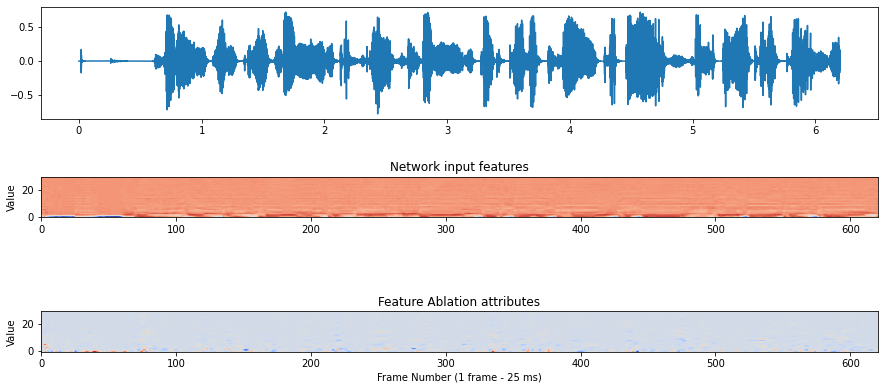

wav_twenties.npy mfcc_twenties.npy
network prediction: [[-6.4007783  16.028076   -9.895983    1.5514097   1.3763075  -6.2818937
   4.435958   -0.78774047]]
predicted: ['twenties'], real class: twenties


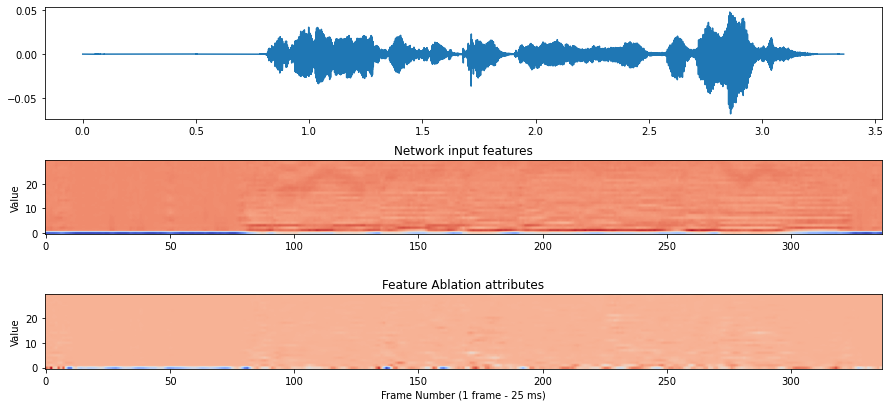

In [6]:
pytorch_embedder = FTDNNXVectorAgeClassifierPytorch(
    ftdnn_params={
        'in_dim': 30,
    },
    classifier_params={
        'embedding_size': 512,
        'num_classes': 8,
        'mode': 'logits'
    }
)

checkpoint_dir = 'pretrained_models/ftdnn/checkpoint.pt'
pytorch_embedder.load_state_dict(torch.load(checkpoint_dir))
pytorch_embedder.eval()

cuda0 = torch.device('cuda:0') 
labels = [
    'teens', 'twenties',  'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'
]
example_id = 0
wavs = sorted(load_wavs(), key=lambda x: x[0])
mfccs = sorted(load_mfccs(), key=lambda x: x[0])
classes = sorted(load_classes(), key=lambda x: x[0])
explain_methods = ['ig', 'fa']
labels_map = dict([(labels[i], i) for i in range(len(labels))])
pytorch_embedder = pytorch_embedder.to(cuda0)
for explain_method in explain_methods:
    for (wav_name, wav), (mfcc_name, mfcc), (class_name, class_) in zip (wavs, mfccs, classes):
        print(wav_name, mfcc_name)
        pytorch_embedder.zero_grad()

        test_input_tensor = torch.FloatTensor(mfcc)
        test_input_tensor = test_input_tensor.to(cuda0)

        with torch.no_grad():
            prediction = pytorch_embedder.forward(test_input_tensor)
            print(f"network prediction: {prediction.detach().cpu().numpy()}")

            real_class = get_real_class(mfcc_name)
            predicted_class = post_process_predictions(prediction.detach(), labels)
            print(f"predicted: {predicted_class}, real class: {real_class}")

        class_label = torch.LongTensor(class_)
        class_label = class_label.to(cuda0)

        if explain_method == 'ig':
            ig = IntegratedGradients(pytorch_embedder)
            test_input_tensor.requires_grad_()        
            attr, delta = ig.attribute(test_input_tensor, target=class_label, return_convergence_delta=True)
            attr = attr.cpu().detach().numpy()
            attribute_plot_title = 'Integrated Gradients attributes'
        elif explain_method == 'fa':
            fa = FeatureAblation(pytorch_embedder)
            attr = fa.attribute(test_input_tensor, target=class_label)
            attr = attr.cpu().detach().numpy()
            attribute_plot_title = 'Feature Ablation attributes'
        else:
            raise ValueError('unrecognized explain method {}'.format(args.explain_method ))

        # plot the results
        fig, axs = plt.subplots(3, 1, sharex=False, sharey=False)
        dpi = 200
        sample_rate = 48000
        axs[0].plot([i/sample_rate for i in range(wav[0].shape[0])], wav[0])

        axs[1].imshow(test_input_tensor.cpu().detach().numpy()[0], cmap=cm.coolwarm, origin='lower')
        axs[1].set_title('Network input features')
        axs[1].set_ylabel('Value')

        axs[2].imshow(attr[0], cmap=cm.coolwarm, origin='lower')
        axs[2].set_title(attribute_plot_title)
        axs[2].set_xlabel('Frame Number (1 frame - 25 ms)')
        axs[2].set_ylabel('Value')
        plt.show()


# Results discussion

1. The Captum Deep Neural Networks explainability framework. 

I have to say that I am very positively surprised by how powerful and at the same time easy to use the Captum framework is. Basically all we need to do in order to make use of mathematically complicated and non-basic methods for Neural Networks explainability is these few lines of code:
```python
if explain_method == 'ig':
    ig = IntegratedGradients(pytorch_embedder)
    test_input_tensor.requires_grad_()        
    attr, delta = ig.attribute(test_input_tensor, target=class_label, return_convergence_delta=True)
elif explain_method == 'fa':
    fa = FeatureAblation(pytorch_embedder)
    attr = fa.attribute(test_input_tensor, target=class_label)
```

2. Explainability algorithms comparison

| method      | Integrated Gradients(IG) | Feature Ablation(FA) |
|-------------|----------------------|------------------|
| speed       | Very Fast            | Slow             |
| reliability | Moderate             | High             |
| insight     | Good                 | Good             |
| flexibility     | Average                 | Good             |

* speed - IG is very fast, as it only needs to propagate back and forth the input feature vector and a baseline vector. FA is slow - it needs to perturb the input vector many times, and on each perturbation run the forward pass. It is at least on a order of magnitude slower. 
* reliability - While for the more shallow TDNN network both methods find important parts in the MFCC seqeunce, the FTDNN with more complicated architecture and more layers does not co-operate well with the heatmaps generated with IG being, for some of the inputs, very uniform and without any distinctive features visible. Feature Ablation managed to find important segments in both cases.
* insight - both methods provide valuable insight about the network. The fact that IG does not find important features may point out some flaw in the architecture implementation or the training process. In fact there was an inconsistency during the training, as the code for constraining the semi-orthogonlaity was not called during the training of the FTDNN network. 
* flexibility - I would say that feature ablation provides user with more flexibility as you can group together segments of the input matrix and ablate them together - that could be really usefull in tasks such as image classification.


3. Explaination matrices
Okay, so in the end what kind of insight did I get from using these methods? Do they provide me with some deeper understanding of how my network works and do they provide a mean to asses that what the network learns are really important features and not overfitting to some artifacts?

Let's start with the first question./ The MFCC are features made to resamble the way human ears interprets speech and in general audio signals. Human hearing system is not linear. A scale that accurately describes the way human perceive frequency is called a mel-scale. 

![mel-scale](./data/info/mel_scale.png)

The MFCCs algorithm can be described as follows [7]:
```
Take the Fourier transform of (a windowed excerpt of) a signal.
Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
Take the logs of the powers at each of the mel frequencies.
Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
The MFCCs are the amplitudes of the resulting spectrum.
```

In simple words, we hear differences in low frequencies very well, but in higher frequencies a bigger difference is needed for us to hear it. The MFCC takes that into account - that is why the lower filters (lower MFCCs) are distributed very tight, modelling small differences in the energy conatined in the lower parts of the specturm, but the higher the filter (coeffcient), the longer frequency range it spans.

Below are some sample Mel-spectrogram - spectrogram whose frequency axis is in mel-scale. 
![mel-spectrogram](./data/info/mel_spectrogram.png)

we can clearly see a characteristic of humans voices - typically, man have lower fundamental frequency then women. Consequently, also higher harmonics, being proportional to this fundamental frequency, are more sparsely distributed in women's voice.

Well, how does age affects the voice then, since here I want to classify age from speech, so there must be some kind of signal, right?
I will just show this diagrams here:
![pitch-change](./data/info/pitch_change_age.png)

![age-voice-changes](./data/info/age_voice_changes2.png)

So given this information, I would expect the explaination matrices to focus on regions of speech that are voiced (we cannot estimate F0 on unvoiced fragments, as they are bascially white-noise-alike) and mainly in the lower part of the spectrum. The overall energy of the signal should be also iportant as well as the formants (harmonics). And indeed, with both methods it shows that the explianation matrices focuses on lower frequencies and mainly discards the unvoiced and silent regions. It also shows some instabilities, like paying attention to some interference here and there, which may point towards a kind of overfitting. 


# Further work

The experiment described here is just a beginning for my Master Thesis I would like to try some more evaluations to make sure that the features highlighted by these algorithms are really important:
* Check how the network behaves when you gradually zero-out random samples as compared to zeroing-out features marked as important - what happens to accuracy.
* Include gender info
